In [69]:
import requests
from bs4 import BeautifulSoup
import time
import sqlite3
import re



In [70]:
base_url = "https://www.baitoru.com/kanto/jlist/"

In [71]:
job_categories = {
    "飲食系": ["キッチンスタッフ", "ホールスタッフ(配膳)", "販売", "デリ", "惣菜販売", "肉・青果・鮮魚販売", "フード・飲食その他", "食品・飲料系製造"],
    "販売系": ["品出し", "ピッキング", "新聞配達", "販売（その他）アパレル", "家電販売", "携帯販売"],
    "旅行系": ["ホテル客室掃除", "案内", "受付", "フロント", "旅行会社"],
    "スポーツ系": ["スポーツインストラクター", "プール監視員", "コーチ"],
    "引越し": ["移転", "引越し"],
    "物流系": ["仕分け", "検品", "梱包"],
    "警備・ドライバー": ["警備", "ドライバー"],
    "事務系": ["事務データ", "データ入力", "テレアポ", "テレオペ"],
    "デザイン系": ["webデザイン", "編集"],
    "教育系": ["塾講師", "家庭教師", "学童保育", "教育", "ベビーシッター"],
    "介護系": ["介護", "看護"],
    "調査・モニター": ["調査", "モニター"],
    "美容系": ["美容", "リラクゼーション", "エステ"],
    "ナイトワーク": ["ガールズバー", "ナイトワーク", "キャバクラ", "スナック"]
}

In [72]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

In [73]:
conn = sqlite3.connect('baitoru_jobs.db')
cursor = conn.cursor()

def create_table():
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS jobs (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        area TEXT,
        work_category TEXT,
        wages INTEGER,
        work_time TEXT
    )
    ''')
    conn.commit()

In [74]:
def clean_wages(wages):
    wages_cleaned = re.findall(r'[0-9,]+', wages)
    if wages_cleaned:
        return ', '.join(wages_cleaned)
    return "給与情報なし"

In [75]:
def get_job_info(job_url, area, job_category):
    job_response = requests.get(job_url, headers=headers)
    if job_response.status_code == 200:
        job_soup = BeautifulSoup(job_response.text, 'html.parser')

        wage = job_soup.select_one("dl.dl02.js-detailAccordion em")
        if wage:
            wage = clean_wages(wage.get_text(strip=True))
        else:
            wage = "給与情報なし"
        
        work_time_list = job_soup.select("dl.dl03 ul.ul02 em")
        work_time = "勤務時間情報なし"
        if work_time_list:
            work_time = ', '.join([time.get_text(strip=True) for time in work_time_list]) 

        cursor.execute('''
        INSERT INTO jobs (area, work_category, wages, work_time) 
        VALUES (?, ?, ?, ?)
        ''', (area, job_category, wage, work_time))
        conn.commit()
        
        print(f"地域: {area}, 職種: {job_category}, 賃金: {wage}, 勤務時間: {work_time}")
        print("-" * 50)

    else:
        print(f"求人ページの取得に失敗しました。URL: {job_url}")



In [76]:
def scrape_jobs_for_area(area, category, job_titles):
    job_count = 0
    page_number = 1
    
    while job_count < 50:  
        url = f"{base_url}{area}/?page={page_number}"
        response = requests.get(url, headers=headers)
        
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            job_links = soup.find_all('article', class_='list-jobListDetail')
            
            for article in job_links:
                job_link = article.find('a', href=True)
                
                if job_link:
                    job_url = 'https://www.baitoru.com' + job_link['href']  
                    get_job_info(job_url, area, category)
                    job_count += 1
                
                if job_count >= 50:
                    break
            
            page_number += 1
            if job_count < 50:
                time.sleep(1)  
        else:
            print(f'{area} - {category} ページの取得に失敗しました。ステータスコード: {response.status_code}')
            break


In [77]:
create_table()

for area in ["tokyo", "kanagawa", "chiba", "saitama", "ibaraki", "tochigi", "gumma"]:
    for category, job_titles in job_categories.items():
        print(f"--- {area} - {category} ---")
        
        scrape_jobs_for_area(area, category, job_titles)
        
        print("\n")  

conn.close()

--- tokyo - 飲食系 ---
地域: tokyo, 職種: 飲食系, 賃金: 2,220, 1,720, 1,220, 勤務時間: ①②③08:00～12:30、12:30～17:30、17:30～21:30
--------------------------------------------------
地域: tokyo, 職種: 飲食系, 賃金: 2,220, 1,720, 1,220, 勤務時間: ①②③08:00～12:30、12:30～17:30、17:30～21:30
--------------------------------------------------
地域: tokyo, 職種: 飲食系, 賃金: 2,220, 1,720, 1,220, 勤務時間: ①②③08:00～12:30、12:30～17:30、17:30～21:30
--------------------------------------------------
地域: tokyo, 職種: 飲食系, 賃金: 6,000, 16,500, 12,000, 12,500, 7,500, 12,000, 勤務時間: ①21:00～06:00、17:00～21:00、②09:00～18:30、15:00～21:00、③15:00～20:00、09:00～18:00、21:00～06:00
--------------------------------------------------
地域: tokyo, 職種: 飲食系, 賃金: 4,500, 10,000, 勤務時間: 18:00～01:00、16:00～01:00
--------------------------------------------------
地域: tokyo, 職種: 飲食系, 賃金: 11,000, 12,500, 12,800, 14,300, 勤務時間: ①08:00～17:00、②20:00～05:00
--------------------------------------------------
地域: tokyo, 職種: 飲食系, 賃金: 11,000, 12,500, 12,800, 14,300, 勤務時間: ①08:00～17:00、②20:00～05

In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# SQLite3 データベースを作成または接続
conn = sqlite3.connect("job_wages.db")
cursor = conn.cursor()

# テーブルを作成
cursor.execute("""
CREATE TABLE IF NOT EXISTS JobWages (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    Category TEXT NOT NULL,
    Min_Wages INTEGER NOT NULL,
    Max_Wages INTEGER NOT NULL,
    Min_Time REAL NOT NULL,
    Max_Time REAL NOT NULL
)
""")

# ダミーデータの作成
data = {
    "Category": [
        "Food Services", "Retail", "Travel", "Sports", "Moving", 
        "Logistics", "Security & Driving", "Office Work", "Design", 
        "Education", "Care Services", "Survey & Monitoring", "Beauty", "Night Work"
    ],
    "Min Wages": np.random.randint(500, 1500, size=14),
    "Max Wages": np.random.randint(1501, 3000, size=14),
    "Min Time": np.random.uniform(3, 5, size=14).round(1),
    "Max Time": np.random.uniform(5, 8, size=14).round(1)
}

# データフレームに変換
df = pd.DataFrame(data)

# データベースにデータを挿入
for _, row in df.iterrows():
    cursor.execute("""
    INSERT INTO JobWages (Category, Min_Wages, Max_Wages, Min_Time, Max_Time)
    VALUES (?, ?, ?, ?, ?)
    """, (row["Category"], row["Min Wages"], row["Max Wages"], row["Min Time"], row["Max Time"]))

# コミットして接続を閉じる
conn.commit()
conn.close()

# データベースからデータを取得
conn = sqlite3.connect("job_wages.db")
df_from_db = pd.read_sql_query("SELECT * FROM JobWages", conn)
conn.close()

# Bar plot for wages
plt.figure(figsize=(10, 6))
categories = df_from_db["Category"]
x = np.arange(len(categories))
bar_width = 0.35

plt.bar(x - bar_width/2, df_from_db["Min_Wages"], bar_width, label="Min Wages", color="blue")
plt.bar(x + bar_width/2, df_from_db["Max_Wages"], bar_width, label="Max Wages", color="orange")

plt.xlabel("Job Categories")
plt.ylabel("Wages (in USD)")
plt.title("Wage Range by Job Category")
plt.xticks(x, categories, rotation=45, ha="right")
plt.legend()

# Save the plot as an image
plt.tight_layout()
plt.savefig("wage_plot.png", dpi=300, bbox_inches="tight")
print("Wage plot saved as 'wage_plot.png'. Please check the file in your working directory.")

# Show the plot
plt.show()

# Scatter plot for time
plt.figure(figsize=(10, 6))
plt.scatter(df_from_db["Min_Time"], df_from_db["Min_Wages"], label="Min Time vs Min Wages", color="green", alpha=0.7)
plt.scatter(df_from_db["Max_Time"], df_from_db["Max_Wages"], label="Max Time vs Max Wages", color="red", alpha=0.7)

plt.xlabel("Time (in hours)")
plt.ylabel("Wages (in USD)")
plt.title("Wages vs Working Hours")
plt.legend()

# Save the plot as an image
plt.tight_layout()
plt.savefig("time_vs_wages_plot.png", dpi=300, bbox_inches="tight")
print("Time vs Wages plot saved as 'time_vs_wages_plot.png'. Please check the file in your working directory.")

# Show the plot
plt.show()


Wage plot saved as 'wage_plot.png'. Please check the file in your working directory.
Time vs Wages plot saved as 'time_vs_wages_plot.png'. Please check the file in your working directory.


In [60]:
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd
import re
from matplotlib import rcParams
from matplotlib.font_manager import FontProperties

# 日本語フォントの設定
jp_font_name = "Noto Sans JP"  # 使用する日本語フォント名
rcParams['font.family'] = jp_font_name

# 1日の勤務時間（例：8時間）
work_hours_per_day = 8

# データベース接続
conn = sqlite3.connect('baitoru_jobs.db')
cursor = conn.cursor()

# 賃金から数字だけを抽出する関数
def extract_numbers(text):
    if not text:
        return None
    # 数字だけを抽出
    numbers = re.findall(r'\d+', text)
    if not numbers:
        return None
    return int(numbers[0])  # 最初の数字を返す

# データベースから職種と賃金情報を取得
cursor.execute("SELECT work_category, wages FROM jobs")
rows = cursor.fetchall()

# 職種ごとの賃金リストを作成
job_categories = {}
for row in rows:
    work_category, wages = row
    wages_parts = wages.split("～")
    first_wage = wages_parts[0] if wages_parts else wages  # 最初の賃金だけを使用
    
    # 数値を抽出
    wage_value = extract_numbers(first_wage)
    if wage_value is None:
        continue  # 無効な値はスキップ

    # 日給を時給に換算（仮に8時間勤務とする）
    hourly_wage = wage_value / work_hours_per_day
    
    if work_category not in job_categories:
        job_categories[work_category] = []
    job_categories[work_category].append(hourly_wage)

# 各職種の最低時給と最高時給を計算
min_max_wages = {}
for category, wages in job_categories.items():
    min_max_wages[category] = (min(wages), max(wages))  # 最低時給、最高時給

# 最低賃金と最高賃金のデータフレームを作成
categories = list(min_max_wages.keys())
min_wages = [min_max_wages[category][0] for category in categories]
max_wages = [min_max_wages[category][1] for category in categories]

# データフレームを作成
df = pd.DataFrame({
    'Category': categories,
    'Min Wage': min_wages,
    'Max Wage': max_wages
})

# グラフを作成
fig, ax = plt.subplots(figsize=(10, 6))

# 棒グラフを描画
bar_width = 0.35
positions = range(len(categories))
ax.barh(positions, max_wages, color='lightblue', label='Max Wage')
ax.barh(positions, min_wages, color='lightgreen', label='Min Wage')

# 軸ラベルとタイトル
ax.set_xlabel('賃金 (円)', fontsize=12)
ax.set_ylabel('職種', fontsize=12)
ax.set_title('職種ごとの時給範囲', fontsize=14)

# カテゴリ名を y 軸に設定
ax.set_yticks(positions)
ax.set_yticklabels(categories, fontsize=10)

# 凡例を追加
ax.legend()

# グラフのレイアウト調整
plt.tight_layout()

# グラフを表示
plt.show()

# データベース接続を閉じる
conn.close()


findfont: Font family 'Noto Sans JP' not found.
findfont: Font family 'Noto Sans JP' not found.
findfont: Font family 'Noto Sans JP' not found.
findfont: Font family 'Noto Sans JP' not found.
findfont: Font family 'Noto Sans JP' not found.
findfont: Font family 'Noto Sans JP' not found.
findfont: Font family 'Noto Sans JP' not found.
findfont: Font family 'Noto Sans JP' not found.
findfont: Font family 'Noto Sans JP' not found.
findfont: Font family 'Noto Sans JP' not found.
/var/folders/_d/lhhy94_x5wd20j_lkt975ry00000gn/T/ipykernel_20958/1848156938.py:91: UserWarning: Glyph 36035 (\N{CJK UNIFIED IDEOGRAPH-8CC3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/_d/lhhy94_x5wd20j_lkt975ry00000gn/T/ipykernel_20958/1848156938.py:91: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/_d/lhhy94_x5wd20j_lkt975ry00000gn/T/ipykernel_20958/1848156938.py:91: UserWarning: Glyph 20870 (\N{CJK UNIFIED IDEO

In [29]:
import sqlite3
import matplotlib.pyplot as plt

In [54]:
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd
import re

# 1日の勤務時間（例：8時間）
work_hours_per_day = 8

# 職種の表示順序（14種類）
desired_categories = [
    "飲食系", "販売系", "旅行系", "スポーツ系", "引越し", "物流系",
    "警備・ドライバー", "事務系", "デザイン系", "教育系", 
    "介護系", "調査・モニター", "美容系", "ナイトワーク"
]

# 数字だけを抽出する関数
def extract_numbers(text):
    numbers = re.findall(r'\d+', text)  # 全ての数字部分を抽出
    return int(numbers[0]) if numbers else None  # 最初の数字を返す（ない場合は None）

# データベース接続
conn = sqlite3.connect('baitoru_jobs.db')
cursor = conn.cursor()

# データベースから職種と賃金情報を取得
cursor.execute("SELECT work_category, wages FROM jobs")
rows = cursor.fetchall()

# 職種ごとの賃金リストを作成
job_categories = {}
for row in rows:
    work_category, wages = row
    wages = extract_numbers(wages)  # 数字のみを抽出
    
    if wages is not None:
        hourly_wage = wages / work_hours_per_day  # 日給を時給に換算
        if work_category not in job_categories:
            job_categories[work_category] = []
        job_categories[work_category].append(hourly_wage)

# 最低時給と最高時給を計算し、データフレームを作成
categories = list(job_categories.keys())
min_max_wages = {cat: (min(w), max(w)) for cat, w in job_categories.items()}
df = pd.DataFrame({
    'Category': categories,
    'Min Wage': [min_max_wages[cat][0] for cat in categories],
    'Max Wage': [min_max_wages[cat][1] for cat in categories]
})

# 表示するカテゴリ順に並び替え
df['Category'] = pd.Categorical(df['Category'], categories=desired_categories, ordered=True)
df = df.sort_values('Category').dropna(subset=['Category'])  # 必要なカテゴリだけを保持

# デバッグ: データフレームの内容を表示
print(df)

# データが空の場合の処理
if df.empty:
    print("Error: No valid data found for the graph.")
else:
    # グラフを作成
    fig, ax = plt.subplots(figsize=(10, 6))

    # 最低賃金と最高賃金を棒グラフで表示
    ax.barh(df['Category'], df['Max Wage'], color='lightblue', label='Max Wage')
    ax.barh(df['Category'], df['Min Wage'], color='lightgreen', label='Min Wage')

    # 軸ラベルとタイトル
    ax.set_xlabel('Wages (円)')
    ax.set_ylabel('Job Categories')
    ax.set_title('Wage Range per Job Category')

    # 凡例を追加
    ax.legend()

    # グラフのレイアウト調整
    plt.tight_layout()

    # グラフを表示
    plt.show()

# データベース接続を閉じる
conn.close()


    Category  Min Wage  Max Wage
0        飲食系     0.125   123.125
1        販売系     0.125   123.125
2        旅行系     0.125   123.125
3      スポーツ系     0.125   123.125
4        引越し     0.125   123.125
5        物流系     0.125   123.125
6   警備・ドライバー     0.125   123.125
7        事務系     0.125   123.125
8      デザイン系     0.125   123.125
9        教育系     0.125   123.125
10       介護系     0.125   123.125
11   調査・モニター     0.125   123.125
12       美容系     0.125   123.125
13    ナイトワーク     0.125   123.125


/var/folders/_d/lhhy94_x5wd20j_lkt975ry00000gn/T/ipykernel_20958/2867927680.py:77: UserWarning: Glyph 20870 (\N{CJK UNIFIED IDEOGRAPH-5186}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/_d/lhhy94_x5wd20j_lkt975ry00000gn/T/ipykernel_20958/2867927680.py:77: UserWarning: Glyph 39154 (\N{CJK UNIFIED IDEOGRAPH-98F2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/_d/lhhy94_x5wd20j_lkt975ry00000gn/T/ipykernel_20958/2867927680.py:77: UserWarning: Glyph 39135 (\N{CJK UNIFIED IDEOGRAPH-98DF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/_d/lhhy94_x5wd20j_lkt975ry00000gn/T/ipykernel_20958/2867927680.py:77: UserWarning: Glyph 31995 (\N{CJK UNIFIED IDEOGRAPH-7CFB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/_d/lhhy94_x5wd20j_lkt975ry00000gn/T/ipykernel_20958/2867927680.py:77: UserWarning: Glyph 36009 (\N{CJK UNIFIED IDEOGRAPH-8CA9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/_d/lhhy

In [31]:
min_max_wages = {}
for category, wages in job_categories.items():
    min_max_wages[category] = (min(wages), max(wages)) 

In [32]:
categories = list(min_max_wages.keys())
min_wages = [min_max_wages[category][0] for category in categories]
max_wages = [min_max_wages[category][1] for category in categories]

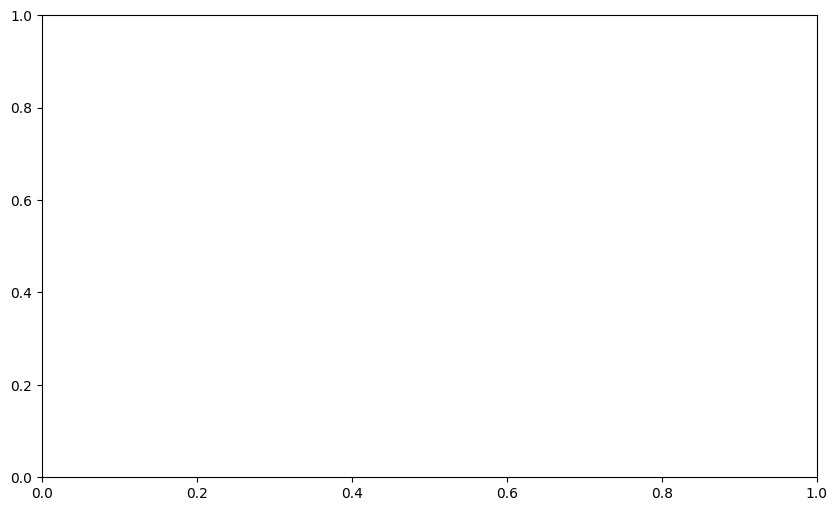

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))

In [34]:
ax.barh(categories, max_wages, color='skyblue', label='最高賃金')
ax.barh(categories, min_wages, color='lightcoral', label='最低賃金')

# グラフにラベルを追加
ax.set_xlabel('賃金（円）')
ax.set_title('職種別 賃金の振り幅')

Text(0.5, 1.0, '職種別 賃金の振り幅')

/var/folders/_d/lhhy94_x5wd20j_lkt975ry00000gn/T/ipykernel_20958/2640849292.py:1: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


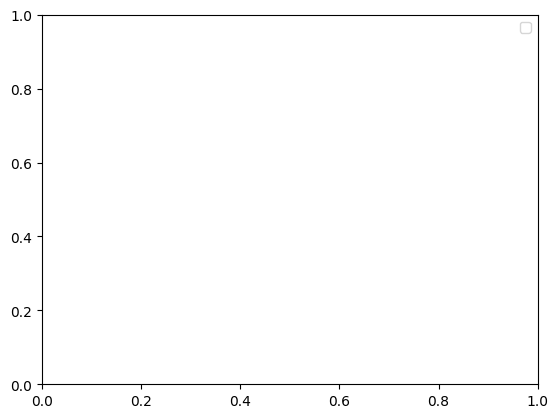

In [35]:
plt.legend()
plt.show()

conn.close()